# Genetic Algorithm through Conventional Machine Learning approach for Classification

## Library Preparation

In [25]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from tqdm import tqdm

## Dataset Preparation

In [26]:
df = pd.read_csv('mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [28]:
# Pemilihan fitur training
y_train = df['class']
x_train = df.drop('class', axis=1)

# Inisialisasi encoder
ohe = OneHotEncoder()
le = LabelEncoder()

# Pengubahan data kategorikal menjadi numerikal
x_train = le.fit_transform(x_train)
y_train = le.fit_transform(y_train)

In [29]:
# Menentukan jumlah fitur secara otomatis
ohe = OneHotEncoder(categories='auto')
sc = StandardScaler()

# Pengubahan data ke dalam bentuk array
x_train = ohe.fit_transform(x_train).toarray()

# Normalisasi data
x_train = sc.fit_transform(x_train)

In [30]:
# Pembagian data training, validasi, dan testing
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

## Artificial Neural Network Architecture

In [31]:
# Mendefinisiakan fungsi aktivasi
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

# Mendefinisikan fungsi forward propagation
def forward(x, w, activation):
    return activation(np.matmul(x, w))

# Fungsi untuk menghitung akurasi
def accuracy_fn(y, y_hat):
    return (np.where(y == y_hat)[0].size / y_hat.size)

# Mendefinisikan fungsi untuk melakukan perhitungan feedforward 
def predict(x, y_hat, weights, activation):
    predictions = np.zeros(shape=(x.shape[0]))
    
    for idx in range(x.shape[0]):
        r1 = x[idx, :]
        for curr_weights in weights:
            r1 = forward(r1, curr_weights, activation)
        predictions[idx] = np.where(r1 == np.max(r1))[0][0]

    accuracy = accuracy_fn(predictions, y_hat)
    return accuracy, predictions

# Mendefinisikan fungsi untuk menghitung akurasi untuk setiap set bobot 
def fitness(x, y_hat, weights, activation):
    accuracy = np.empty(shape=(weights.shape[0]))
    
    for idx in range(weights.shape[0]):
        accuracy[idx], _ = predict(x, y_hat, weights[idx, :], activation)
    return accuracy

### Vector-Matrix Manipulations

In [32]:
# 
def mat_to_vector(mat_pop_weights):
    pop_weights_vector = []
    
    for sol_idx in range(mat_pop_weights.shape[0]):
        curr_vector = []
        
        for layer_idx in range(mat_pop_weights.shape[1]):
            vector_weights = np.reshape(mat_pop_weights[sol_idx, layer_idx], newshape=(mat_pop_weights[sol_idx, layer_idx].size))
            curr_vector.extend(vector_weights)
        pop_weights_vector.append(curr_vector)

    return np.array(pop_weights_vector)

def vector_to_mat(vector_pop_weights, mat_pop_weights):
    mat_weights = []
    
    for sol_idx in range(mat_pop_weights.shape[0]):
        start = 0
        end = 0
        
        for layer_idx in range(mat_pop_weights.shape[1]):
            end = end + mat_pop_weights[sol_idx, layer_idx].size
            curr_vector = vector_pop_weights[sol_idx, start:end]
            mat_layer_weights = np.reshape(curr_vector, newshape=(mat_pop_weights[sol_idx, layer_idx].shape))
            mat_weights.append(mat_layer_weights)
            start = end
            
    return np.reshape(mat_weights, newshape=mat_pop_weights.shape)

## Genetic Algorithm Architecture

In [33]:
def mating_pool(pop, fitness, num_parents):
    parents = np.empty((num_parents, pop.shape[1]))
    
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99
        
    return parents

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint32(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        
        parent1_idx = k%parents.shape[0]
        parent2_idx = (k+1)%parents.shape[0]
        
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
        
    return offspring

def mutation(offspring_crossover, mutation_percent):
    num_mutations = np.uint32((mutation_percent*offspring_crossover.shape[1]))
    mutation_indices = np.array(random.sample(range(0, offspring_crossover.shape[1]), num_mutations))
    
    for idx in range(offspring_crossover.shape[0]):
        random_value = np.random.uniform(-1.0, 1.0, 1)
        offspring_crossover[idx, mutation_indices] = offspring_crossover[idx, mutation_indices] + random_value
    
    return offspring_crossover

### Parameters

In [34]:
solution_per_population = 8
num_parents_mating = 4
num_generations = 100
mutation_percent = 0.20

In [35]:
input_shape = x_train.shape[1]
output_shape = len(np.unique(y_train))

### Weight Initialization

In [36]:
initial_weights = []
for curr_sol in np.arange(0, solution_per_population):
    
    w1 = np.random.uniform(low=-0.1, high=0.1, size=(input_shape, 128))
    w2 = np.random.uniform(low=-0.1, high=0.1, size=(128, 64))
    w3 = np.random.uniform(low=-0.1, high=0.1,size=(64, output_shape))

    initial_weights.append(np.array([w1, w2, w3]))

C:\Users\akmal\AppData\Local\Temp\ipykernel_2252\910789126.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  initial_weights.append(np.array([w1, w2, w3]))


In [37]:
weights_mat = np.array(initial_weights)
weights_vector = mat_to_vector(weights_mat)

best_outputs = []
accuracies = np.empty(shape=(num_generations))

## Training

In [38]:
for generation in tqdm(range(num_generations)):

    # vector to matrix
    weights_mat = vector_to_mat(weights_vector, weights_mat)

    # fitness of the population
    fit = fitness(x_train, y_train, weights_mat, activation=sigmoid)
    
    # assign first fitness to the array
    accuracies[generation] = fit[0]

    # selecting mating parents from pool
    parents = mating_pool(weights_vector, fit.copy(), num_parents_mating)

    # generate new population using crossover
    offspring_crossover = crossover(parents, offspring_size=(weights_vector.shape[0]-parents.shape[0], weights_vector.shape[1]))

    # adding mutation to the population
    offspring_mutation = mutation(offspring_crossover, mutation_percent=mutation_percent)
    
    # new population combining parents of crossver and mut
    weights_vector[0:parents.shape[0], :] = parents
    weights_vector[parents.shape[0]:, :] = offspring_mutation

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\akmal\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
100%|██████████| 100/100 [07:14<00:00,  4.34s/it]


## Analysis

In [39]:
weights_mat = vector_to_mat(weights_vector, weights_mat)
best_weights = weights_mat [0, :]
acc, predictions = predict(x_train, y_train, best_weights, sigmoid)
print("Accuracy of the best solution is : ", acc)

Accuracy of the best solution is :  0.7750615546957439


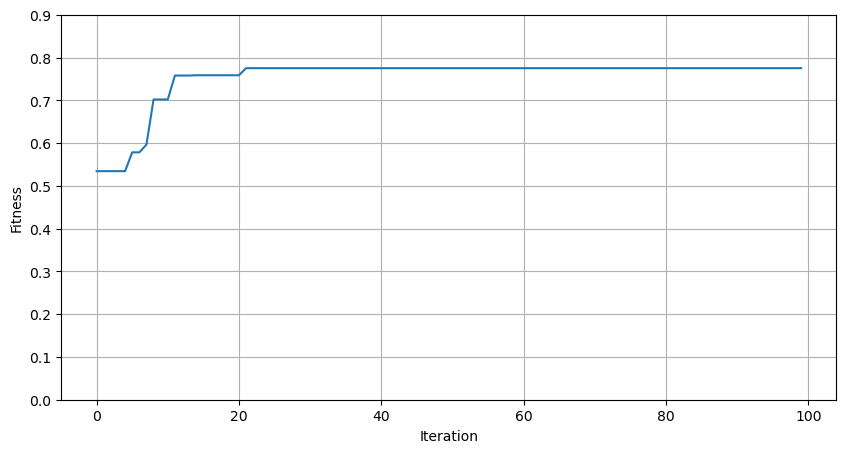

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(accuracies)
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.yticks(np.arange(0, 1, 0.1))
plt.show()

## References

https://www.linkedin.com/pulse/introduction-optimization-genetic-algorithm-ahmed-gad/
>
https://www.kdnuggets.com/2018/03/introduction-optimization-with-genetic-algorithm.html
>
https://towardsdatascience.com/introduction-to-optimization-with-genetic-algorithm-2f5001d9964b
>
https://www.springer.com/us/book/9781484241660